Seed state - 12345


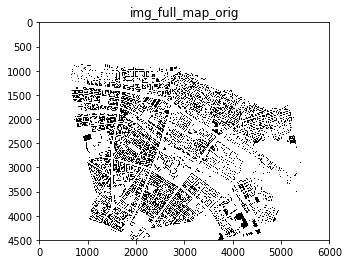

27

In [1]:
from __future__ import print_function
from __future__ import division

import os
import pickle
import sys

import numpy as np
np.set_printoptions(precision=4, suppress=True)

# Freeze seed - Must be called before import of Keras!
seed = 12345
np.random.seed(seed)
print("Seed state - {seed}".format(seed=seed))

import cv2
from visualize import OrthoData, imshow
%matplotlib inline


project_base_dir = '/home/moti/cg/project'

data_sessions_outputs = os.path.join(project_base_dir, 'sessions_outputs')
model_sessions_outputs = os.path.join(project_base_dir, 'meshNet/sessions_outputs')

data_dir = os.path.join(data_sessions_outputs, 'berlinRoi_-1600_-800_1600_1600_GridStep10')

results_dir = os.path.join(project_base_dir, 'meshNet', 'results')

map_data_dir = 'visualization_map'
map_file_path = os.path.join(map_data_dir, 'gSamplesMap.png')
img_full_map_orig = cv2.imread(map_file_path)
orth_data = OrthoData(map_data_dir)

imshow('img_full_map_orig', cv2.resize(img_full_map_orig, (0, 0), fx=0.5, fy=0.5))

In [2]:
def calc_manhattan_dist_stats(y_true, y_pred, xy_step, k=100):
    x_manhattan_distance = abs(y_true[:, 0] - y_pred[:, 0]) // xy_step
    y_manhattan_distance = abs(y_true[:, 1] - y_pred[:, 1]) // xy_step

    xy_manhattan_distance = x_manhattan_distance + y_manhattan_distance
    xy_hist = np.zeros(k, dtype=np.int)
    for i in range(k):
        xy_hist[i] = np.sum(xy_manhattan_distance == i)

    # print("xy_manhattan_distance hist:", xy_hist[:k])

    xy_manhattan_dist_distribution = xy_hist[:k] / float(len(xy_manhattan_distance))
    # print("xy_manhattan_distance hist:", xy_manhattan_dist_distribution)
    return xy_manhattan_dist_distribution

In [3]:
def draw_on_map(img_map, orth_data, p, color, roi=None):
    map_p = orth_data.convert_world_point_to_map(p, img_map.shape)

    # cv_azul_color = (255, 255, 0)
    # cv_green_color = (0, 255, 0)
    # cv_red_color = (0, 0, 255)
    # cv_yellow_color = (45, 205, 243)

    if type(color) == np.float64 or type(color) == int:
        c = color
    else:
        c = (int(tuple(color)[0]), int(tuple(color)[1]), int(tuple(color)[2]))

    cv2.circle(img_map, center=map_p, radius=12, color=c, thickness=cv2.FILLED)

    if roi is not None:
        left, top, width, height = roi
        img_map = img_map[top:top + height, left:left + width]

In [4]:
def find_result_by_xy(results, p):
    for r in results:
        if np.array_equal(r[0:2], p):
            return r[2]
    return -1

def get_interpolation_vis_stats(pickle_file_path, metric_max_dist):
    print('get_interpolation_vis_stats: Entered. metric_max_dist:', metric_max_dist)
    
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
        
    fix = True  # Fill missing values

    mesh_name = data['mesh_name']
    roi = data['roi']
    grid_step = data['grid_step']
    x_type = data['x_type']
    y_type = data['y_type']

#     print(mesh_name)
    print('roi', roi)
    print('grid_step', grid_step)
    print(x_type)
    print(y_type)

    y_test_true = data['y_test_true']
    y_test_pred = data['y_test_pred']

#     full_xy_manhattan_dist_distribution = \
#                     calc_manhattan_dist_stats(y_test_true, y_test_pred, grid_step, k=10)
#     print("full_xy_manhattan_dist_distribution", full_xy_manhattan_dist_distribution)

    x_test_range = range(roi[0] + grid_step // 2, roi[0] + roi[2], grid_step)
    y_test_range = range(roi[1] + grid_step // 2, roi[1] + roi[3], grid_step)
    results = np.zeros([len(x_test_range) * len(y_test_range), 3], dtype=np.float)
    results_idx = 0
    for x in x_test_range:
        for y in y_test_range:
            temp = np.equal(y_test_true[:, :2], [x, y])
            cur_idx = np.logical_and(temp[:, 0], temp[:, 1])

            y_test_true_cur = y_test_true[cur_idx]
            y_test_pred_cur = y_test_pred[cur_idx]

            if y_test_true_cur.size == 0:
                # FIX missing points in data-
                map_p = orth_data.convert_world_point_to_map((x, y), img_full_map_orig.shape)
#                 print(x,y,map_p,img_full_map_orig[map_p[0], map_p[1]] )
                
                if fix and np.array_equal(img_full_map_orig[map_p[1], map_p[0]], [255, 255, 255]):
                    results[results_idx] = [x, y, -1]    
                else:
                    results[results_idx] = [x, y, 0]
            else:
                xy_manhattan_dist_distribution = \
                    calc_manhattan_dist_stats(y_test_true_cur, y_test_pred_cur, grid_step, k=10)

                # print(xy_manhattan_dist_distribution)
                results[results_idx] = [x, y, sum(xy_manhattan_dist_distribution[:metric_max_dist])]
                # print(results)

            results_idx += 1
        
#     print(results)
#     print ("Mean of results", np.mean(results[:, 2]))
        
    # Iterate over -1 results and estimate them
    fixed_results = results.copy()
    if fix:
        for i in xrange(len(fixed_results)):
            if fixed_results[i][2] == -1:
                neighborhood_sum = 0
                neighborhood_count = 0
                neighborhood_offsets = np.array([[-grid_step, 0], [grid_step, 0], [0, -grid_step], [0, grid_step]])
                neighborhood_pts = neighborhood_offsets + fixed_results[i][0:2]
                # print('fixed_results[i][0:2]', fixed_results[i][0:2])
                # print(neighborhood_pts)
                for n in neighborhood_pts:
                    val = find_result_by_xy(results, n)
                    if val != -1:
                        neighborhood_sum += val
                        neighborhood_count += 1
                fixed_results[i][2] = neighborhood_sum / neighborhood_count if neighborhood_count else 0                
    
    print('get_interpolation_vis_stats: Done')
    return fixed_results

In [9]:
import time
from tqdm import tqdm
from scipy import spatial

def nearest_neighbour(y_true, y_pred, k=5):
    tree = spatial.cKDTree(y_true)
    return tree.query(y_pred, k)

def get_matching_vis_stats(pickle_file_path, metric_max_dist):
    print('get_matching_vis_stats: Entered. metric_max_dist:', metric_max_dist)
    
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
        
    fix = True  # Fill missing values

    mesh_name = data['mesh_name']
    roi = data['roi']
    grid_step = data['grid_step']
    x_type = data['x_type']
    y_type = data['y_type']

#     print(mesh_name)
    print('roi', roi)
    print('grid_step', grid_step)
    print(x_type)
    print(y_type)

    y_train_true = data['y_train_true']
    y_train_pred = data['y_train_pred']
    
    k = 5
#     print("Nearest neighbors:", k)
#     print("y_train_true size:", y_train_true.shape[0])
#     print("y_train_pred size:", y_train_pred.shape[0])

#     start_time = time.time()
    nn = nearest_neighbour(y_train_true, y_train_pred, k)
#     end_time = time.time()
#     print("Nearest_neighbour ", nn)
#     print("Nearest_neighbour took {:.3f} seconds".format(end_time - start_time))

    x_train_range = range(roi[0], roi[0] + roi[2], grid_step)
    y_train_range = range(roi[1], roi[1] + roi[3], grid_step)
    results = np.zeros([len(x_train_range) * len(y_train_range), 3], dtype=np.float)
    results_idx = 0
    indices_array = np.array(range(len(y_train_true)))
    for x in tqdm(x_train_range):
        for y in y_train_range:
            temp = np.equal(y_train_true[:, :2], [x, y])
            cur_idx = np.logical_and(temp[:, 0], temp[:, 1])

            if any(cur_idx):     
                hist = np.zeros(k, dtype=np.int)
                for i in indices_array[cur_idx]:
                    for j in range(len(nn[1][i])):
                        if i == nn[1][i][j]:
                            hist[j] += 1
                            break

                nn_ratio = hist / float(sum(cur_idx))
                results[results_idx] = [x, y, sum(nn_ratio[:metric_max_dist])]

    #             print('results_idx', results_idx)
    #             print(sum(cur_idx))
    #             print()
    #             print(nn[1][cur_idx])
    #             print('done')
    #             done = True
    #             break
            else:
                # FIX missing points in data-
                map_p = orth_data.convert_world_point_to_map((x, y), img_full_map_orig.shape)
#                 print(x,y,map_p,img_full_map_orig[map_p[0], map_p[1]] )
                
                if fix and np.array_equal(img_full_map_orig[map_p[1], map_p[0]], [255, 255, 255]):
                    results[results_idx] = [x, y, -1]    
                else:
                    results[results_idx] = [x, y, 0]

            results_idx += 1
        
#     print(results)
#     print ("Mean of results", np.mean(results[:, 2]))
        
    # Iterate over -1 results and estimate them
    fixed_results = results.copy()
    if fix:
        for i in xrange(len(fixed_results)):
            if fixed_results[i][2] == -1:
                neighborhood_sum = 0
                neighborhood_count = 0
                neighborhood_offsets = np.array([[-grid_step, 0], [grid_step, 0], [0, -grid_step], [0, grid_step]])
                neighborhood_pts = neighborhood_offsets + fixed_results[i][0:2]
                # print('fixed_results[i][0:2]', fixed_results[i][0:2])
                # print(neighborhood_pts)
                for n in neighborhood_pts:
                    val = find_result_by_xy(results, n)
                    if val != -1:
                        neighborhood_sum += val
                        neighborhood_count += 1
                fixed_results[i][2] = neighborhood_sum / neighborhood_count if neighborhood_count else 0                
    
    print('get_matching_vis_stats: Done')
    return fixed_results


In [10]:
def create_heatmap(pickle_file_path, isManhattan=True, metric_max_dist=3,
               resize_factor = 0.5, blur_size = 71, show=True, write_way=False):
    print('create_heatmap: Entered. isManhattan:', isManhattan, 
          'metric_max_dist:', metric_max_dist)
    
    output_dir = os.path.join(os.path.dirname(pickle_file_path), os.path.pardir, 'post_visualizations')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    filename_no_ext = os.path.splitext(os.path.split(pickle_file_path)[1])[0] 

    if isManhattan:
        vis_stats = get_interpolation_vis_stats(pickle_file_path, metric_max_dist)
    else:
        vis_stats = get_matching_vis_stats(pickle_file_path, metric_max_dist)
    # print(vis_stats)

    scores = 1 - vis_stats[:, 2]
    scores = np.round(scores * 255).astype(np.uint8)
    colors = cv2.applyColorMap(scores, cv2.COLORMAP_JET)


    # Full map with heatmap circles in estimation points 
    img_full_map = img_full_map_orig.copy()
    for idx, elm in enumerate(vis_stats):
        draw_on_map(img_full_map, orth_data, elm[:2], colors[idx][0], roi=None)

    if show:
        imshow('img_full_map', cv2.resize(img_full_map, (0, 0), fx=resize_factor, fy=resize_factor))
    file_path = os.path.join(output_dir, 'img_full_map.png')
    if write_way:
        cv2.imwrite(file_path, img_full_map)
    print("img_full_map done")


    # Full map with heatmap circles in estimation points 
    scores_map = np.zeros((img_full_map.shape[0], img_full_map.shape[1], 1), dtype=np.uint8)
    for idx, elm in enumerate(vis_stats):
        draw_on_map(scores_map, orth_data, elm[:2], int(vis_stats[:, 2][idx] * 255), roi=None)

    scores_map = cv2.resize(scores_map, (0, 0), fx=resize_factor, fy=resize_factor)
    if show:
        imshow('scores_map', scores_map)
    file_path = os.path.join(output_dir, 'scores_map.png')
    if write_way:
        cv2.imwrite(file_path, scores_map)
    print("scores_map done")
    

    smooth = cv2.GaussianBlur(scores_map, (blur_size, blur_size), 0)
    smooth = cv2.normalize(smooth, smooth, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    if show:
        imshow('smooth', smooth)
    file_path = os.path.join(output_dir, 'smooth.png')
    if write_way:
        cv2.imwrite(file_path, smooth)
    print("smooth done")

    
    color_scores = cv2.applyColorMap(smooth, cv2.COLORMAP_JET)
    if show:
        imshow('color_scores', color_scores)
    file_path = os.path.join(output_dir, 'color_scores.png')
    if write_way:
        cv2.imwrite(file_path, color_scores)
    print("color_scores done")


    print("Applying smoothed color scores onto the actual map (top view)")
    heatmap = cv2.resize(img_full_map_orig, (0, 0), fx=resize_factor, fy=resize_factor)

    sol = 2  # Best
    if sol == 0:
        def update_pixel(p):
            return [255, 255, 255, p[3], p[4], p[5]] if np.array_equal(p[:3], [0, 0, 0]) else [p[3], p[4], p[5], p[3], p[4], p[5]]

        fat_mat = np.dstack((heatmap, color_scores))
        fat_mat = np.apply_along_axis(update_pixel, 2, fat_mat)
        heatmap = fat_mat[:, :, :3]
    elif sol == 1:
        for x in xrange(heatmap.shape[1]):
            for y in xrange(heatmap.shape[0]):
                if not np.array_equal(heatmap[y, x], [0, 0, 0]):
                        heatmap[y, x] = color_scores[y, x]
                else:
                    heatmap[y, x] = [255, 255, 255]
            print("\rIn loop", 100 * x / heatmap.shape[1], "%", end="")
    else:
        # https://stackoverflow.com/questions/44242795/numpy-scipy-with-masks-and-rgb-images
        mask = (heatmap == [0, 0, 0]).all(-1)
        heatmap[mask] = [255, 255, 255]
        heatmap[np.logical_not(mask)] = color_scores[np.logical_not(mask)]

    if show:
        imshow('heatmap', heatmap)
    file_path = os.path.join(output_dir, 'heatmap_' + filename_no_ext + '.png')
    cv2.imwrite(file_path, heatmap)
    print("heatmap saved. Full path:", file_path)


In [13]:
from utils import get_files_with_ext

grid_step_10_path = os.path.join(results_dir, 'gridStep10')
grid_step_20_path = os.path.join(results_dir, 'gridStep20')
grid_step_40_path = os.path.join(results_dir, 'gridStep40')


pkl_list_10 = get_files_with_ext(grid_step_10_path, ext_list=('.pkl'), recursive=True, abs_path=True,
                                 sort=True, warn_empty=True)
for pkl_file in pkl_list_10:
    is_interpolation = True if pkl_file.find('val_loss') != -1 else False
    print('is_interpolation:', is_interpolation, ', pickle:', pkl_file)

    metric_max_dist = 3 if is_interpolation else 1
    create_heatmap(pkl_file, isManhattan=is_interpolation, metric_max_dist=metric_max_dist,
                   blur_size = 31, show=False)

    print('done iteration')


pkl_list_20 = get_files_with_ext(grid_step_20_path, ext_list=('.pkl'), recursive=True, abs_path=True,
                                 sort=True, warn_empty=True)
for pkl_file in pkl_list_20:
    is_interpolation = True if pkl_file.find('val_loss') != -1 else False
    print('is_interpolation:', is_interpolation, ', pickle:', pkl_file)

    metric_max_dist = 3 if is_interpolation else 1
    create_heatmap(pkl_file, isManhattan=is_interpolation, metric_max_dist=metric_max_dist,
                   blur_size = 71, show=False)

    print('done iteration')


pkl_list_40 = get_files_with_ext(grid_step_40_path, ext_list=('.pkl'), recursive=True, abs_path=True,
                                 sort=True, warn_empty=True)
for pkl_file in pkl_list_40:
    is_interpolation = True if pkl_file.find('val_loss') != -1 else False
    print('is_interpolation:', is_interpolation, ', pickle:', pkl_file)

    metric_max_dist = 3 if is_interpolation else 1
    create_heatmap(pkl_file, isManhattan=is_interpolation, metric_max_dist=metric_max_dist,
                   blur_size = 91, show=False)

    print('done iteration')


Getting files from [/home/moti/cg/project/meshNet/results/gridStep10], ext list [.pkl], recursive [True], abs_path [True], sort [True]
is_interpolation: False , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_16-07_53_21_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_edges/pickle/meshNet_best_loss_weights.e236-loss0.01148-vloss0.0541.pkl
create_heatmap: Entered. isManhattan: False metric_max_dist: 1
get_matching_vis_stats: Entered. metric_max_dist: 1
roi (-1200, -400, 400, 400)
grid_step 10
edges
quaternion


100%|██████████| 40/40 [06:57<00:00, 10.45s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_16-07_53_21_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e236-loss0.01148-vloss0.0541.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_16-07_53_21_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_edges/pickle/meshNet_best_val_loss_weights.e200-loss0.01211-vloss0.0534.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 10
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 40/40 [07:03<00:00, 10.60s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_19-05_40_52_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01143-vloss0.0426.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_19-05_40_52_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e196-loss0.01214-vloss0.0408.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 10
stacked_faces
quaternion
get_interpolation_vis_stats: Done
img_full_map do

100%|██████████| 40/40 [07:00<00:00, 10.51s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_22-03_06_56_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e237-loss0.01115-vloss0.0439.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_400_400/meshNet_2018_08_22-03_06_56_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep10_quaternion_depth/pickle/meshNet_best_val_loss_weights.e205-loss0.01164-vloss0.0409.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 10
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 80/80 [1:55:10<00:00, 86.39s/it]   


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_800_800/meshNet_2018_10_31-19_44_54_Train_resnet_120Epochs_berlin_ROI_-1200_-400_800_800_GridStep10_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e119-loss0.01232-vloss0.0580.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1200_-400_800_800/meshNet_2018_10_31-19_44_54_Train_resnet_120Epochs_berlin_ROI_-1200_-400_800_800_GridStep10_quaternion_edges/pickle/meshNet_best_val_loss_weights.e117-loss0.01236-vloss0.0578.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 800, 800)
grid_step 10
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 40/40 [02:09<00:00,  3.23s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_12-09_10_36_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01232-vloss0.0707.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_12-09_10_36_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_edges/pickle/meshNet_best_val_loss_weights.e237-loss0.01242-vloss0.0695.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -400, 400, 400)
grid_step 10
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_13-16_38_36_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e238-loss0.01251-vloss0.0523.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_13-16_38_36_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e194-loss0.01350-vloss0.0498.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -400, 400, 400)
grid_step 10
stacked_faces
quaternion
get_interpolation_vis_stats: Done
img_full_map do

100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_15-00_07_47_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e238-loss0.01270-vloss0.0606.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep10/-1600_-400_400_400/meshNet_2018_08_15-00_07_47_Train_resnet_240Epochs_berlin_ROI_-1600_-400_400_400_GridStep10_quaternion_depth/pickle/meshNet_best_val_loss_weights.e228-loss0.01303-vloss0.0566.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -400, 400, 400)
grid_step 10
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_07-19_17_35_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01574-vloss0.1835.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_07-19_17_35_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_edges/pickle/meshNet_best_val_loss_weights.e231-loss0.01609-vloss0.1813.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 20
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_08-19_15_29_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e237-loss0.01653-vloss0.1438.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_08-19_15_29_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e235-loss0.01654-vloss0.1398.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 20
stacked_faces
quaternion
get_interpolation_vis_stats: Done
img_full_map do

100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_09-19_25_37_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e237-loss0.01601-vloss0.1409.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1200_-400_400_400/meshNet_2018_08_09-19_25_37_Train_resnet_240Epochs_berlin_ROI_-1200_-400_400_400_GridStep20_quaternion_depth/pickle/meshNet_best_val_loss_weights.e226-loss0.01628-vloss0.1395.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1200, -400, 400, 400)
grid_step 20
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 80/80 [1:10:11<00:00, 52.64s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_1600_1600/meshNet_2018_10_18-11_03_39_Train_resnet_240Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep20_quaternion_edges/meshNet_2018_10_26-15_31_27_TrainResume_resnet_162Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep20_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e161-loss0.01571-vloss0.2335.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_1600_1600/meshNet_2018_10_18-11_03_39_Train_resnet_240Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep20_quaternion_edges/meshNet_2018_10_26-15_31_27_TrainResume_resnet_162Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep20_quaternion_edges/pickle/meshNet_best_val_loss_weights.e161-loss0.01571-vloss0.2335.pkl
create_h

100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_05-08_52_47_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01916-vloss0.2343.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_05-08_52_47_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_edges/pickle/meshNet_best_val_loss_weights.e238-loss0.01927-vloss0.2304.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 400, 400)
grid_step 20
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_05-20_19_46_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e238-loss0.01823-vloss0.1731.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_05-20_19_46_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e237-loss0.01837-vloss0.1702.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 400, 400)
grid_step 20
stacked_faces
quaternion
get_interpolation_vis_stats: Done
img_full_map do

100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_06-07_57_30_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01870-vloss0.1728.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_400_400/meshNet_2018_08_06-07_57_30_Train_resnet_240Epochs_berlin_ROI_-1600_-800_400_400_GridStep20_quaternion_depth/pickle/meshNet_best_val_loss_weights.e223-loss0.01897-vloss0.1702.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 400, 400)
grid_step 20
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 40/40 [03:35<00:00,  5.39s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_800_800/meshNet_2018_12_02-14_56_54_Train_resnet_240Epochs_berlin_ROI_-1600_-800_800_800_GridStep20_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.01371-vloss0.2317.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-1600_-800_800_800/meshNet_2018_12_02-14_56_54_Train_resnet_240Epochs_berlin_ROI_-1600_-800_800_800_GridStep20_quaternion_edges/pickle/meshNet_best_val_loss_weights.e217-loss0.01424-vloss0.2301.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 800, 800)
grid_step 20
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map done
smoot

100%|██████████| 40/40 [06:02<00:00,  9.07s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_14-00_32_04_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e238-loss0.01256-vloss0.1962.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_14-00_32_04_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_edges/pickle/meshNet_best_val_loss_weights.e225-loss0.01282-vloss0.1956.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map don

100%|██████████| 40/40 [06:02<00:00,  9.07s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_17-13_53_59_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e237-loss0.01171-vloss0.1291.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_17-13_53_59_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e212-loss0.01210-vloss0.1286.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
stacked_faces
quaternion
get_interpolation_vis_stats: Done
img_full

100%|██████████| 40/40 [06:01<00:00,  9.04s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_21-03_04_00_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e238-loss0.01143-vloss0.1340.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_21-03_04_00_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_depth/pickle/meshNet_best_val_loss_weights.e228-loss0.01163-vloss0.1320.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scores_map don

100%|██████████| 40/40 [06:02<00:00,  9.06s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_26-15_00_20_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_edges_MESS/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.07572-vloss1.1793.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_26-15_00_20_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_edges_MESS/pickle/meshNet_best_val_loss_weights.e011-loss1.05151-vloss1.0057.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scor

100%|██████████| 40/40 [06:00<00:00,  9.01s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_29-04_52_21_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces_MESS/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.07328-vloss1.1977.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_06_29-04_52_21_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces_MESS/pickle/meshNet_best_val_loss_weights.e006-loss1.09784-vloss0.9913.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
stacked_faces
quaternion
get_interpolation_vis_stats: Don

100%|██████████| 40/40 [06:03<00:00,  9.08s/it]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_07_01-17_24_33_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_depth_MESS/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e239-loss0.08216-vloss1.2682.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep20/-800_-800_800_800/meshNet_2018_07_01-17_24_33_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_depth_MESS/pickle/meshNet_best_val_loss_weights.e008-loss1.10234-vloss0.9993.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, -800, 800, 800)
grid_step 20
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map done
scor

100%|██████████| 40/40 [00:11<00:00,  3.61it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-11_32_30_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e118-loss0.07342-vloss1.1804.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-11_32_30_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_edges/pickle/meshNet_best_val_loss_weights.e005-loss1.05664-vloss1.0823.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 1600, 1600)
grid_step 40
edges
quaternion
get_interpolation_vis_stats: Done
i

  0%|          | 0/40 [00:00<?, ?it/s]

heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-11_32_30_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_edges/pickle/../post_visualizations/heatmap_meshNet_best_val_loss_weights.e005-loss1.05664-vloss1.0823.png
done iteration
is_interpolation: False , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-14_12_48_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_stacked_faces/pickle/meshNet_best_loss_weights.e118-loss0.07114-vloss1.1720.pkl
create_heatmap: Entered. isManhattan: False metric_max_dist: 1
get_matching_vis_stats: Entered. metric_max_dist: 1
roi (-1600, -800, 1600, 1600)
grid_step 40
stacked_faces
quaternion


100%|██████████| 40/40 [00:11<00:00,  3.61it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-14_12_48_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_stacked_faces/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e118-loss0.07114-vloss1.1720.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-14_12_48_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_stacked_faces/pickle/meshNet_best_val_loss_weights.e107-loss0.08039-vloss1.1150.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 1600, 1600)
grid_step 40
stacked_faces
quaternion
get_interpo

100%|██████████| 40/40 [00:11<00:00,  3.62it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-16_49_46_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e117-loss0.07184-vloss1.0845.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-16_49_46_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_depth/pickle/meshNet_best_val_loss_weights.e022-loss0.83203-vloss1.0494.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-1600, -800, 1600, 1600)
grid_step 40
depth
quaternion
get_interpolation_vis_stats: Done
i

 20%|██        | 4/20 [00:00<00:00, 34.44it/s]

heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-1600_-800_1600_1600/2_pitch_8_yaw/meshNet_2018_11_11-16_49_46_Train_resnet_120Epochs_berlin_ROI_-1600_-800_1600_1600_GridStep40_quaternion_depth/pickle/../post_visualizations/heatmap_meshNet_best_val_loss_weights.e022-loss0.83203-vloss1.0494.png
done iteration
is_interpolation: False , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-15_21_29_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_edges_BATCH_8/pickle/meshNet_best_loss_weights.e118-loss0.08723-vloss1.0424.pkl
create_heatmap: Entered. isManhattan: False metric_max_dist: 1
get_matching_vis_stats: Entered. metric_max_dist: 1
roi (-800, 0, 800, 800)
grid_step 40
edges
quaternion


100%|██████████| 20/20 [00:01<00:00, 18.97it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-15_21_29_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_edges_BATCH_8/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e118-loss0.08723-vloss1.0424.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-15_21_29_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_edges_BATCH_8/pickle/meshNet_best_val_loss_weights.e105-loss0.09643-vloss1.0117.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, 0, 800, 800)
grid_step 40
edges
quaternion
get_interpolation_vis_stats: Done
img_full_map do

 20%|██        | 4/20 [00:00<00:00, 36.26it/s]

heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-15_21_29_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_edges_BATCH_8/pickle/../post_visualizations/heatmap_meshNet_best_val_loss_weights.e105-loss0.09643-vloss1.0117.png
done iteration
is_interpolation: False , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-16_39_46_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_stacked_faces_BATCH_8/pickle/meshNet_best_loss_weights.e118-loss0.09459-vloss1.4362.pkl
create_heatmap: Entered. isManhattan: False metric_max_dist: 1
get_matching_vis_stats: Entered. metric_max_dist: 1
roi (-800, 0, 800, 800)
grid_step 40
stacked_faces
quaternion


100%|██████████| 20/20 [00:00<00:00, 20.26it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-16_39_46_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_stacked_faces_BATCH_8/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e118-loss0.09459-vloss1.4362.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-16_39_46_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_stacked_faces_BATCH_8/pickle/meshNet_best_val_loss_weights.e099-loss0.11112-vloss1.0734.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, 0, 800, 800)
grid_step 40
stacked_faces
quaternion
get_interpolation_vis_sta

 20%|██        | 4/20 [00:00<00:00, 34.42it/s]

heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-16_39_46_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_stacked_faces_BATCH_8/pickle/../post_visualizations/heatmap_meshNet_best_val_loss_weights.e099-loss0.11112-vloss1.0734.png
done iteration
is_interpolation: False , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-17_57_06_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_depth_BATCH_8/pickle/meshNet_best_loss_weights.e119-loss0.10224-vloss0.9712.pkl
create_heatmap: Entered. isManhattan: False metric_max_dist: 1
get_matching_vis_stats: Entered. metric_max_dist: 1
roi (-800, 0, 800, 800)
grid_step 40
depth
quaternion


100%|██████████| 20/20 [00:01<00:00, 18.69it/s]


get_matching_vis_stats: Done
img_full_map done
scores_map done
smooth done
color_scores done
Applying smoothed color scores onto the actual map (top view)
heatmap saved. Full path: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-17_57_06_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_depth_BATCH_8/pickle/../post_visualizations/heatmap_meshNet_best_loss_weights.e119-loss0.10224-vloss0.9712.png
done iteration
is_interpolation: True , pickle: /home/moti/cg/project/meshNet/results/gridStep40/-800_0_800_800/2_pitch_8_yaw/meshNet_2018_11_11-17_57_06_Train_resnet_120Epochs_berlin_ROI_-800_0_800_800_GridStep40_quaternion_depth_BATCH_8/pickle/meshNet_best_val_loss_weights.e114-loss0.10763-vloss0.9615.pkl
create_heatmap: Entered. isManhattan: True metric_max_dist: 3
get_interpolation_vis_stats: Entered. metric_max_dist: 3
roi (-800, 0, 800, 800)
grid_step 40
depth
quaternion
get_interpolation_vis_stats: Done
img_full_map do

In [ ]:
# pickle_file_path = os.path.join(results_dir,
#                             'meshNet_2018_06_17-13_53_59_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces',
#                             'pickle', 'meshNet_best_loss_weights.e237-loss0.01171-vloss0.1291.pkl')
# pickle_file_path = os.path.join(results_dir,
#                             'meshNet_2018_06_17-13_53_59_TrainResume_resnet_240Epochs_berlin_ROI_-800_-800_800_800_GridStep20_quaternion_stacked_faces',
#                             'pickle', 'meshNet_best_val_loss_weights.e212-loss0.01210-vloss0.1286.pkl')

pickle_file_path = os.path.join(results_dir,
                            'meshNet_2018_11_13-12_46_35_TestResume_resnet_215Epochs_berlin_ROI_-1600_-800_800_800_GridStep20_quaternion_edges-TEST-on-best-loss',
                            'pickle', 'meshNet_best_loss_weights.e213-loss0.01469-vloss0.2351.pkl')
# create_heatmap(pickle_file_path, isManhattan=True, metric_max_dist=3)

create_heatmap(pickle_file_path, isManhattan=True, metric_max_dist=1)
